In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
outlier_fraction = 0.01
df = pd.read_csv(os.getcwd()+"\\Data\\realKnownCause\\realKnownCause\\ambient_temperature_system_failure.csv")

In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

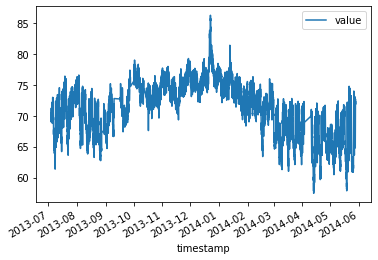

In [4]:
df.plot(x="timestamp",y="value")

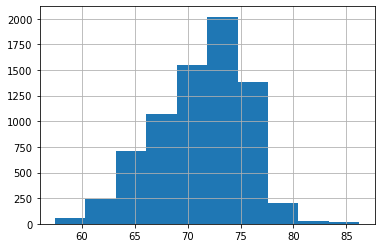

In [5]:
df["value"].hist()

In [6]:
df["hour"]=df["timestamp"].dt.hour
df["DayofWeek"] = df["timestamp"].dt.dayofweek

In [7]:
df['WeekDay'] = (df['DayofWeek'] < 5).astype(int)

In [8]:
df['daylight'] = ((df['hour'] >= 7) & (df['hour'] <= 22)).astype(int)

In [9]:
df["WeekDay"].value_counts()

1    5243
0    2024
Name: WeekDay, dtype: int64

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
data = df[["value","hour","DayofWeek","WeekDay","daylight"]]

In [12]:
minmax = MinMaxScaler()
scaled_data = minmax.fit_transform(data)

In [13]:
data=pd.DataFrame(scaled_data)

In [14]:
from sklearn.decomposition import PCA
pc = PCA(n_components=2)

In [15]:
dim_red_data = pc.fit_transform(data)

In [16]:
scaler = StandardScaler()

In [17]:
dim_red_data2 = scaler.fit_transform(dim_red_data)

In [18]:
pd.DataFrame(dim_red_data2)

,0,1
0,-0.235858,1.636088
1,-0.245149,1.597195
2,-0.248571,1.560250
3,-0.246493,1.525131
4,-0.252241,1.487415
...,...,...
7262,-0.673435,-0.479781
7263,-0.677364,-0.516894
7264,-0.681539,-0.554089
7265,-0.685384,-0.591174


In [19]:
from sklearn.cluster import KMeans
k_cluster = KMeans(n_clusters=4)

In [20]:
k_cluster.fit(dim_red_data2)

KMeans(n_clusters=4)

In [21]:
import numpy
numpy.__version__
#==1.21.4

'1.21.4'

In [22]:
df["cluster_no"]=k_cluster.predict(dim_red_data2)

In [23]:
df["cluster_no"].value_counts()

0    3502
3    1741
1    1344
2     680
Name: cluster_no, dtype: int64

In [24]:
df["prin_feature1"] = pd.DataFrame(dim_red_data2)[0]

df["prin_feature2"] = pd.DataFrame(dim_red_data2)[1]

# dim_red_data2[1] 

In [25]:
colors = {0:'red', 1:'blue', 2:'green', 3:'pink'}

In [26]:
import seaborn as sns

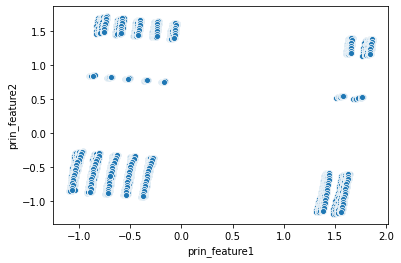

In [36]:
sns.scatterplot(x=df["prin_feature1"],y=df["prin_feature2"])#,df["cluster_no"].apply(lambda x:colors[x]))

In [53]:
# k_cluster.cluster_centers_[k_cluster.labels_]
# set(k_cluster.labels_)
k_cluster.cluster_centers_[3][0]

-0.4343255653799379

In [37]:
df["cluster_no"].value_counts()

0    3502
3    1741
1    1344
2     680
Name: cluster_no, dtype: int64

In [41]:
dim_red_data2 = pd.DataFrame(dim_red_data2)

In [54]:
df["clust_cent_p1"] = df["cluster_no"].apply(lambda x: k_cluster.cluster_centers_[x][0])
df["clust_cent_p2"] = df["cluster_no"].apply(lambda x: k_cluster.cluster_centers_[x][1])

In [65]:
import math

df["distance"] = (df["prin_feature1"]-df["clust_cent_p1"])**2 + (df["prin_feature2"]-df["clust_cent_p2"])**2
df["distance"] = df["distance"].apply(lambda x: math.sqrt(x))

In [77]:
dict_threshold={}

In [86]:
round(df.groupby(df["cluster_no"])["distance"].count()*0.01)

cluster_no
0    35.0
1    13.0
2     7.0
3    17.0
Name: distance, dtype: float64

In [120]:
dict_threshold=round(df.groupby(df["cluster_no"])["distance"].count()*0.01).to_dict()

In [129]:
def return_threshold_dist(cluster_no):
    return df[df["cluster_no"]==cluster_no].sort_values(by="distance",ascending=False).head(int(dict_threshold[cluster_no]))["distance"].min()

In [135]:
df["anomaly"]=(df["distance"] >= df["cluster_no"].apply(return_threshold_dist)).astype(int)

In [137]:
dict_threshold

{0: 35.0, 1: 13.0, 2: 7.0, 3: 17.0}

In [156]:
df.loc[(df["cluster_no"]==3) & (df["anomaly"]==1)]

,timestamp,value,hour,DayofWeek,WeekDay,daylight,cluster_no,prin_feature1,prin_feature2,clust_cent_p1,clust_cent_p2,distance,anomaly
591,2013-07-29 23:00:00,74.798114,23,0,1,0,3,-0.884460,0.836588,-0.434326,1.449822,0.760708,1
1561,2013-09-16 23:00:00,74.895476,23,0,1,0,3,-0.884800,0.836475,-0.434326,1.449822,0.761000,1
1970,2013-10-07 23:00:00,74.715103,23,0,1,0,3,-0.884170,0.836684,-0.434326,1.449822,0.760459,1
2236,2013-10-21 23:00:00,73.435383,23,0,1,0,3,-0.879704,0.838167,-0.434326,1.449822,0.756627,1
2404,2013-10-28 23:00:00,73.644009,23,0,1,0,3,-0.880433,0.837925,-0.434326,1.449822,0.757251,1
2572,2013-11-04 23:00:00,75.880115,23,0,1,0,3,-0.888236,0.835335,-0.434326,1.449822,0.763956,1
2740,2013-11-11 23:00:00,75.272675,23,0,1,0,3,-0.886116,0.836039,-0.434326,1.449822,0.762132,1
3076,2013-11-25 23:00:00,75.995506,23,0,1,0,3,-0.888639,0.835201,-0.434326,1.449822,0.764303,1
3244,2013-12-02 23:00:00,76.088931,23,0,1,0,3,-0.888965,0.835093,-0.434326,1.449822,0.764584,1
3412,2013-12-09 23:00:00,74.540686,23,0,1,0,3,-0.883562,0.836886,-0.434326,1.449822,0.759936,1
